<a href="https://colab.research.google.com/github/SoSneaks/CS-301_Project_1/blob/master/CS_301_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We began with the [Basic Starter Kernel](https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model ) 
All NYC taxi information can be found at: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page


Project 2 - Weather Taxi Fare Prediction                               
Christopher Im                                               
Juan Gonzalez

### Initial Setup

Things we need to do to start the project since were taking the data from our google drive. To run this code, make sure you have a folder named "data" in your google drive with the file "train.csv" in it.

In [ ]:
# Initial Python environment setup...
import numpy as np 
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns 
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline 
import matplotlib.pyplot as plt
import os  
print(os.listdir('/content/drive/My Drive/data')) 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['train.csv', 'test.csv', 'weather.csv', 'submit.csv', 'submission.csv']


### Import the data and add features
First let's read in our data. The entire dataset is too large, so we're using the first 15,000 rows.

In [ ]:
data_df =  pd.read_csv('/content/drive/My Drive/data/train.csv', nrows = 15_000, parse_dates = ['pickup_datetime']).drop(columns = 'key')
data_df = data_df.sort_values('pickup_datetime').reset_index(drop=True) # sort dataframe by date

Read in the weather data to be used in conjunction with other features.

In [ ]:
weather_df =  pd.read_csv('https://arrival.streamanalytix.com/s/8YpsJan76SDFfNj/download', parse_dates = ['DATE']).drop(columns = ['STATION','NAME'])

Change date to match the format in the input dataframe.

In [ ]:
weather_df['DATE'] = pd.to_datetime(weather_df['DATE']).dt.date

Add rain and snow data to the data frame and another feature for weather that is either snow or rain (This takes a while to do)

In [ ]:


data_df['RAIN'] = 0
data_df['SNOW'] = 0
data_df['WEATHER'] = 0

for ind,date in enumerate(weather_df['DATE']):
  for ind2,date2 in enumerate(data_df['pickup_datetime']):
    if date == date2.date():
      if weather_df.loc[ind,'PRCP'] > 0:
        data_df.loc[ind2,'RAIN'] = 1
        data_df.loc[ind2,'WEATHER'] = 1
        data_df.loc[ind2,'SNOW'] = 0
      if weather_df.loc[ind,'SNOW'] > 0:
        data_df.loc[ind2,'SNOW'] = 1
        data_df.loc[ind2,'WEATHER'] = 1
        data_df.loc[ind2,'RAIN'] = 0
      

There's a couple features that might be important for us to have to be able to get a closer look at the data.

Adding a longitude and latitude distance value will give us the manhattan distance from the pickup point and the drop off point.  We think that distance traveled will have a large impact on being able to predict fare prices.

Adding a separate feature for the year, month, and day might also prove to be useful for being able to predict fare prices for our training model.

In [ ]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    df['manhattan'] = df['abs_diff_longitude'] + df['abs_diff_latitude']

add_travel_vector_features(data_df)

In [ ]:
import calendar

data_df ['pickup_datetime']=pd.to_datetime(data_df['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
data_df ['pickup_date']= data_df['pickup_datetime'].dt.date
data_df ['pickup_day']=data_df['pickup_datetime'].apply(lambda x:x.day)
# data_df ['pickup_hour']=data_df['pickup_datetime'].apply(lambda x:x.hour)
data_df ['pickup_day_of_week']=data_df['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
data_df ['pickup_month']=data_df['pickup_datetime'].apply(lambda x:x.month)
data_df ['pickup_year']=data_df['pickup_datetime'].apply(lambda x:x.year)

In [ ]:
print('Old size: %d' % len(data_df))
data_df = data_df[(data_df.abs_diff_longitude < 1.0) & (data_df.abs_diff_latitude < 1.0) &
                  (data_df.pickup_latitude >= 40.55) & (data_df.pickup_latitude <= 40.9) &
                  (data_df.pickup_longitude >= -74.05) & (data_df.pickup_longitude <= -73.71) &
                  (data_df.dropoff_latitude >= 40.55) & (data_df.dropoff_latitude <= 40.9) &
                  (data_df.dropoff_longitude >= -74.05) & (data_df.dropoff_longitude <= -73.71)]
print('New size: %d' % len(data_df))

Old size: 15000
New size: 14612


### Clean our data.
If there are any NaN's in the data, its incomplete and must be removed.

In [ ]:
print('Old size: %d' % len(data_df))
data_df = data_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(data_df))

Old size: 14612
New size: 14612


Since we only care about the NYC area, an absolute Long or Lat of > 1 will mean they are basically outside the NYC range as 1 Long/Lat is approximately 69 miles. 

I used this website to give me a range of longitude and latitude and came up with a range of [-74.05, -73.71] for longitude, and a range of [40.55, 40.9] for latitude

[Lat/Long on mouse cursor](https://www.findlatitudeandlongitude.com/?lat=41.68142205277912&lon=-82.68436074256897&zoom=13&map_type=G_NORMAL_MAP)

Now that we have removed the invalid and outliers for longitude and latitudes,  
we can import Geopy to calculate a more precise distance between the pickup and dropoff points in Kilometers and add that as a feature

In order to charge a fare, there must be at least one person in the taxi.  NYC law also states that you cant have more than 7 people in the cab so data with less than 0 passengers and more than 7 passengers must be removed from the data.

If the manhattan distance or geopy distance is 0, the taxi did not actually move anywhere so the fare would be 0 in that case anyway.  We will remove data where the taxi didn't move anywhere.  I think a case for distance travelled less than 0.3048 kilometers (~1000 feet) can be removed from the data as well.

In [ ]:
from geopy.distance import geodesic # get distance in Kilometers

def getDistance(df):
  distance = []
  for row in df.itertuples():
    origin = (row.pickup_latitude, row.pickup_longitude)
    end = (row.dropoff_latitude, row.dropoff_longitude)
    distance.append(geodesic(origin, end).km )
  df['distance'] = distance
  
getDistance(data_df)

In [ ]:
print('Old size: %d' % len(data_df))
data_df = data_df[(data_df.passenger_count > 0) & (data_df.passenger_count <= 7)]
data_df = data_df[(data_df.manhattan > 0) & (data_df.distance > .1)]
print('New size: %d' % len(data_df))

Old size: 14612
New size: 14339


Some fares are way too high and some are negative. Taking the fares and looking at their percentile to remove outliers seems like the best choice here.

In [ ]:
for row in ['fare_amount']:
     print(f'{row.capitalize():17}: 99.99% = {round(np.percentile(data_df[row], 99.99), 2):5} \t 99.999% = {round(np.percentile(data_df[row], 99.999), 2)}')

Fare_amount      : 99.99% = 75.19 	 99.999% = 103.32


In [ ]:
print('Old size: %d' % len(data_df))
data_df = data_df[(data_df.fare_amount > 0) & (data_df.fare_amount <= (135.26))]
print('New size: %d' % len(data_df))

Old size: 14339
New size: 14337


In creating the Manhattan borough, we chose to limit it to the densest area of activity which is from upper midtown all the way down.

In [ ]:
# data_df[data_df.WEATHER == 1] 
# manhattan box (-74.0196928896,40.6989142057,-73.9496273779,40.797)

manhattan_df = data_df[(data_df.dropoff_longitude < -73.9496273779) & (data_df.pickup_longitude < -73.9496273779) & 
                       (data_df.dropoff_longitude > -74.0196928896) & (data_df.pickup_longitude > -74.0196928896) &
                       (data_df.dropoff_latitude < 40.797) & (data_df.pickup_latitude < 40.797) &
                       (data_df.dropoff_latitude > 40.6991093873) & (data_df.pickup_latitude > 40.6991093873)
                       ]

### Lets Take a look at our data for MANHATTAN after removing the outliers

Now that the outliers and incomplete data is taken out, we can see the graph of Manhattan on the right fits our linear model much better than the NYC graph.

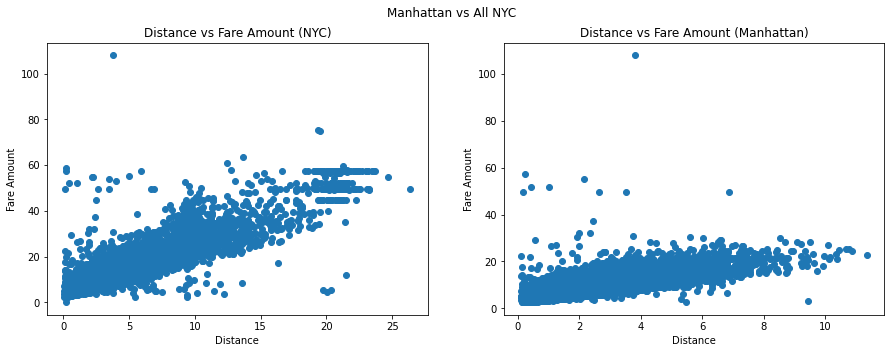

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(data_df['distance'],data_df['fare_amount'])
ax[0].set_xlabel("Distance"); ax[0].set_ylabel("Fare Amount"); ax[0].set_title("Distance vs Fare Amount (NYC)");

ax[1].scatter(manhattan_df['distance'],manhattan_df['fare_amount'])
ax[1].set_xlabel("Distance"); ax[1].set_ylabel("Fare Amount"); ax[1].set_title("Distance vs Fare Amount (Manhattan)");

fig.suptitle('Manhattan vs All NYC')
plt.show()

Sort Manhattan Dataframe by pickup longitude and latitude

In [ ]:
manhattan_df = manhattan_df.sort_values(['pickup_longitude','pickup_latitude']).reset_index(drop=True)
print('there are',len(manhattan_df),'rows')

there are 11295 rows


Divide Manhattan dataframe into 100 equal parts.



In [ ]:
import math

zone_size = len(manhattan_df)//100

def index_marks(nrows, zone_size):
    return range(zone_size, math.ceil(nrows / zone_size) * zone_size, zone_size)

def split(manhattan_df, chunk_size): 
    indices = index_marks(manhattan_df.shape[0], chunk_size)
    return np.split(manhattan_df, indices)

zones = split(manhattan_df, 100) # these can be use in a number of ways later
print('there are',len(zones),'zones')

there are 113 zones


<center>train_X$\space = X =\begin{pmatrix}(x_1) \\(x_2) \\.\\.\\(x_n)\end{pmatrix}$

Where $x_i$ is a matrix of features of the ith row in the train_data Dataframe
<center>train_y$\space = [y_1,\space y_2,\space y_3,\space... y_{n-2},\space y_{n-1},\space y_n]$

Where y_i is the fare amount for the ith row in the train_data Dataframe

 We can use the Mean Squared Error or Root Mean Squared Error to see how acurate our model is. <center>$$ MSE = { \frac{1}{n}\sum_{i=1}^{n}\Big(y_i - \hat{y_i}\Big)^2}\space\space\space\space\space  RMSE = \sqrt{ \frac{1}{n}\sum_{i=1}^{n}\Big(y_i - \hat{y_i}\Big)^2}$$
 Where n = len(test_data), y = predicted, and $\hat{y_i}$ = the actual

Using the sklearn toolkit to do a linear regression model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Construct and return an input matrix for our linear model
# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.distance, df.manhattan, df.WEATHER, df.SNOW, df.RAIN, np.ones(len(df))))

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))


def test_train(zone): # calculate rmse for all zones

  train_data, test_data = train_test_split(zone, test_size=0.20) # We can now split our data into training and testing sets of 80% and 20% respectively.

  test_data = test_data.drop('fare_amount', axis=1)
  test_data = test_data.dropna(how = 'any', axis = 'rows')

  train_X = get_input_matrix(train_data) # This is the X matrix
  train_y = np.array(train_data['fare_amount'])

  (w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)

  test_X = get_input_matrix(test_data)
  test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

  X_train = train_X[:len(test_data)]

  model = LinearRegression() 
  model.fit(train_X,train_y) # fit the model to the training data
  prediction = model.predict(X_train) # make a prediction
  target = train_y[:len(prediction)] # train_y = np.array(train_data['fare_amount'])
  
  # ax.scatter(prediction,target)


  rmse = mean_squared_error(target, prediction, squared=False)

  return rmse
i=1
rmse_List = []
for zone in zones:
  zone['zone'] = i # add zone id to each row
  zone['rmse'] = test_train(zone)
  i+=1
  rmse_List.append(test_train(zone)) # list of rmse for each zone


plt.show()

manhattan_df = pd.concat(zones).reset_index(drop=True) # rebuild manhattan_df with new values
test_train(manhattan_df)

2.8671196912451475

Each row in the dataframe now has zone and rmse data.

In [ ]:
good_weather = manhattan_df[(manhattan_df.WEATHER == 0)]
bad_weather = manhattan_df[(manhattan_df.WEATHER == 1)]

We want to make a heatmap of weather data with drop off and pick up latitudes and longitudes. Need to put them into bins to see how many pickups/dropoffs there are in an area to be able to draw the heatmap that will show the density of each area.

In [ ]:
BB = (-74.1, -73.7, 40.6, 40.85)
nyc_map = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon))

bins_lon = np.zeros(n_lon+1)
bins_lat = np.zeros(n_lat+1)
delta_lon = (BB[1]-BB[0]) / n_lon
delta_lat = (BB[3]-BB[2]) / n_lat
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat


inds_pickup_lon = np.digitize(data_df.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(data_df.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(data_df.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(data_df.dropoff_latitude, bins_lat)

dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

Now that we have everything set up, we can now plot the data with the weather conditions in mind over a map of NYC

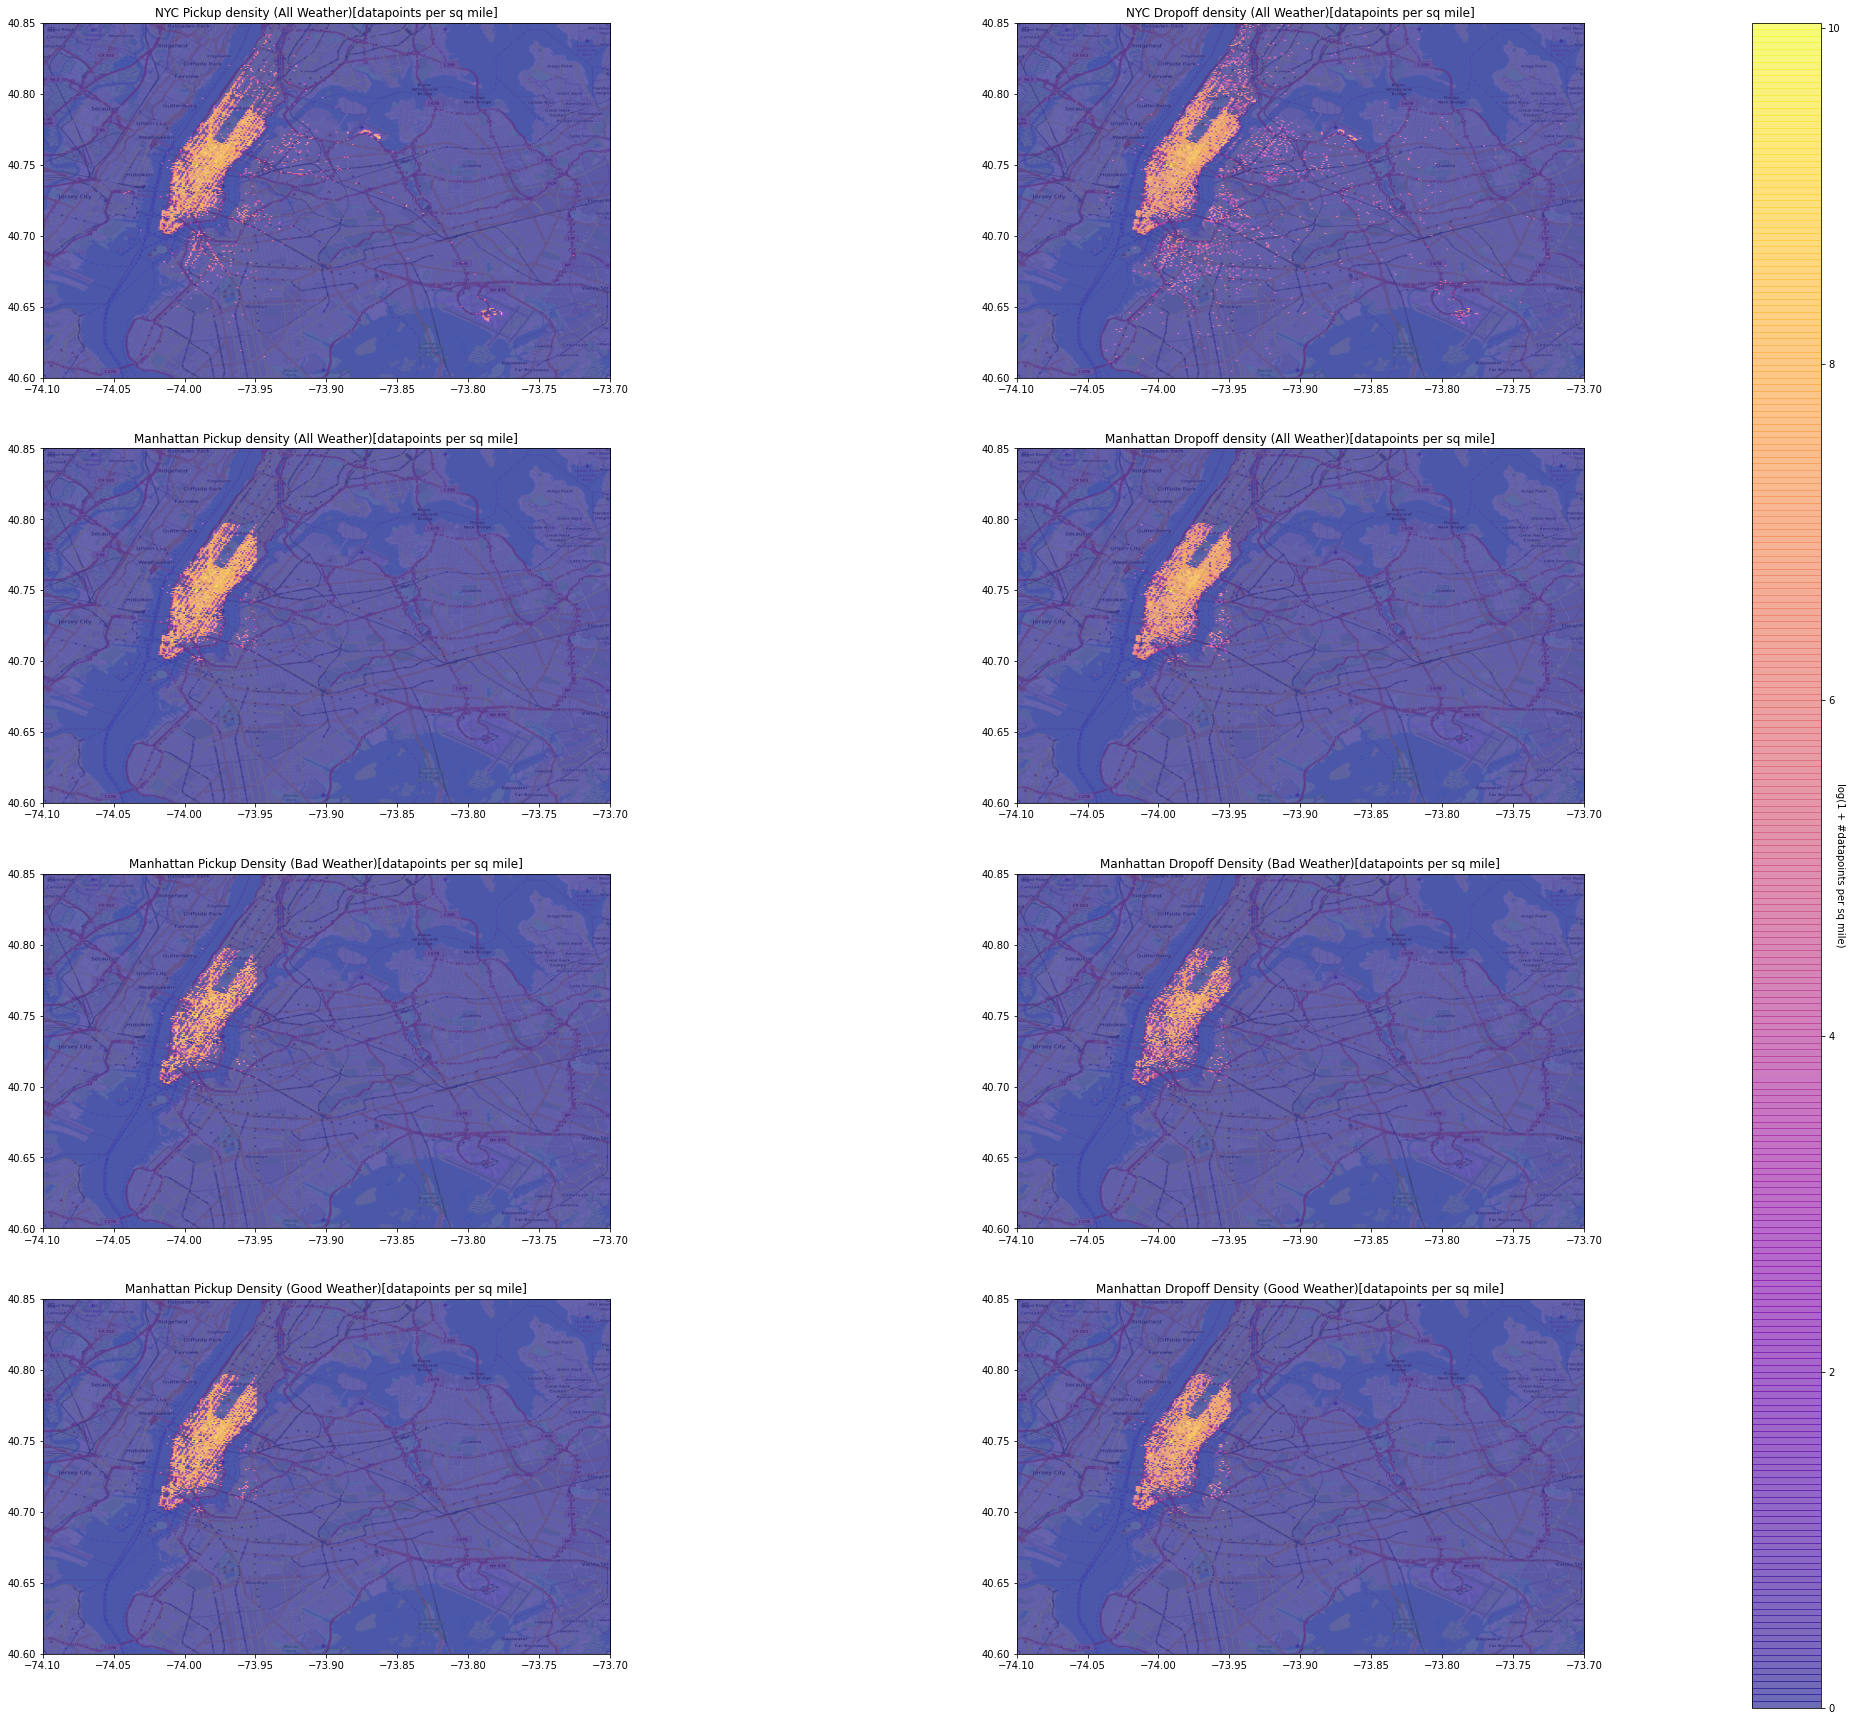

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(4, 2, figsize=(32, 30))
axs[0,0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0,0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0,0].set_title('NYC Pickup density (All Weather)[datapoints per sq mile]')

axs[0,1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0,1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0,1].set_title('NYC Dropoff density (All Weather)[datapoints per sq mile]')
# cbar = fig.colorbar(im, ax=axs[0,1])
# cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

inds_pickup_lon = np.digitize(manhattan_df.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(manhattan_df.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(manhattan_df.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(manhattan_df.dropoff_latitude, bins_lat)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

axs[1,0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1,0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1,0].set_title('Manhattan Pickup density (All Weather)[datapoints per sq mile]')

axs[1,1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1,1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1,1].set_title('Manhattan Dropoff density (All Weather)[datapoints per sq mile]')

cax = plt.axes([.92, 0.1, 0.03, 0.78])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

inds_pickup_lon = np.digitize(bad_weather.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(bad_weather.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(bad_weather.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(bad_weather.dropoff_latitude, bins_lat)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

axs[2,0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[2,0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[2,0].set_title('Manhattan Pickup Density (Bad Weather)[datapoints per sq mile]')

axs[2,1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[2,1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[2,1].set_title('Manhattan Dropoff Density (Bad Weather)[datapoints per sq mile]')

inds_pickup_lon = np.digitize(good_weather.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(good_weather.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(good_weather.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(good_weather.dropoff_latitude, bins_lat)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

axs[3,0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[3,0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[3,0].set_title('Manhattan Pickup Density (Good Weather)[datapoints per sq mile]')

axs[3,1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[3,1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[3,1].set_title('Manhattan Dropoff Density (Good Weather)[datapoints per sq mile]')

plt.show()

Another plot to be able to look at the data in a line to compare fare amount to the weather conditions in each zone that we split Manhatten into.


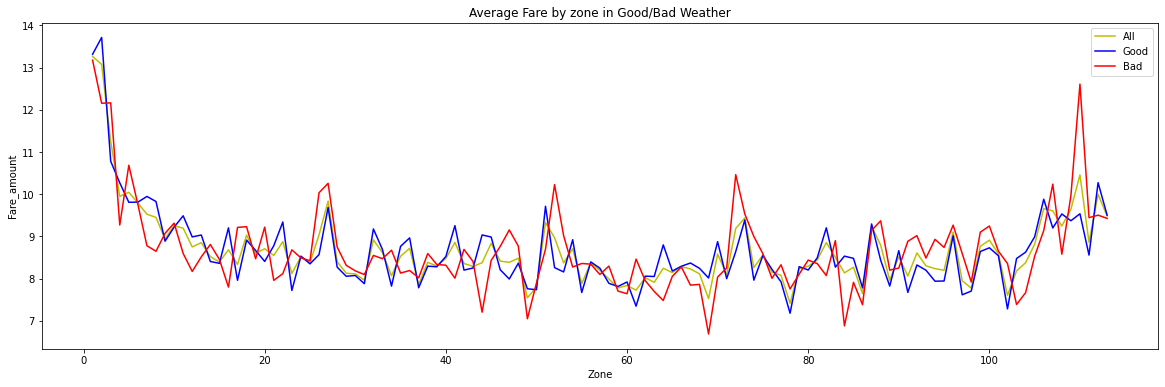

Good weather average fare 8.649567294929648 
Bad weather average fare 8.701451741558094
The average RMSE is: 2.2064973094045066 
The min RMSE is: 1.0043479999165683 
The max RMSE is: 11.603066151684876


In [ ]:
ax = plt.gca()
manhattan_df.groupby('zone')['fare_amount'].mean().plot(color = 'y',figsize=(20,6), ax=ax, label='All')
good_weather.groupby('zone')['fare_amount'].mean().plot(kind="line",color = 'b', ax= ax, label='Good')
bad_weather.groupby('zone')['fare_amount'].mean().plot(kind="line",color = 'r', ax= ax, label='Bad')


ax.set_title('Average Fare by zone in Good/Bad Weather');

ax.set_xlabel('Zone'); 
ax.set_ylabel('Fare_amount');

plt.legend()
plt.show()
print('Good weather average fare', good_weather['fare_amount'].mean(),'\nBad weather average fare', bad_weather['fare_amount'].mean())
print('The average RMSE is:',sum(rmse_List)/len(rmse_List), '\nThe min RMSE is:', min(rmse_List), '\nThe max RMSE is:', max(rmse_List))

As you can see from the graph. Although fares during bad weather are only slightly higher (about 6 cents) the fares range more widely than in good weather.

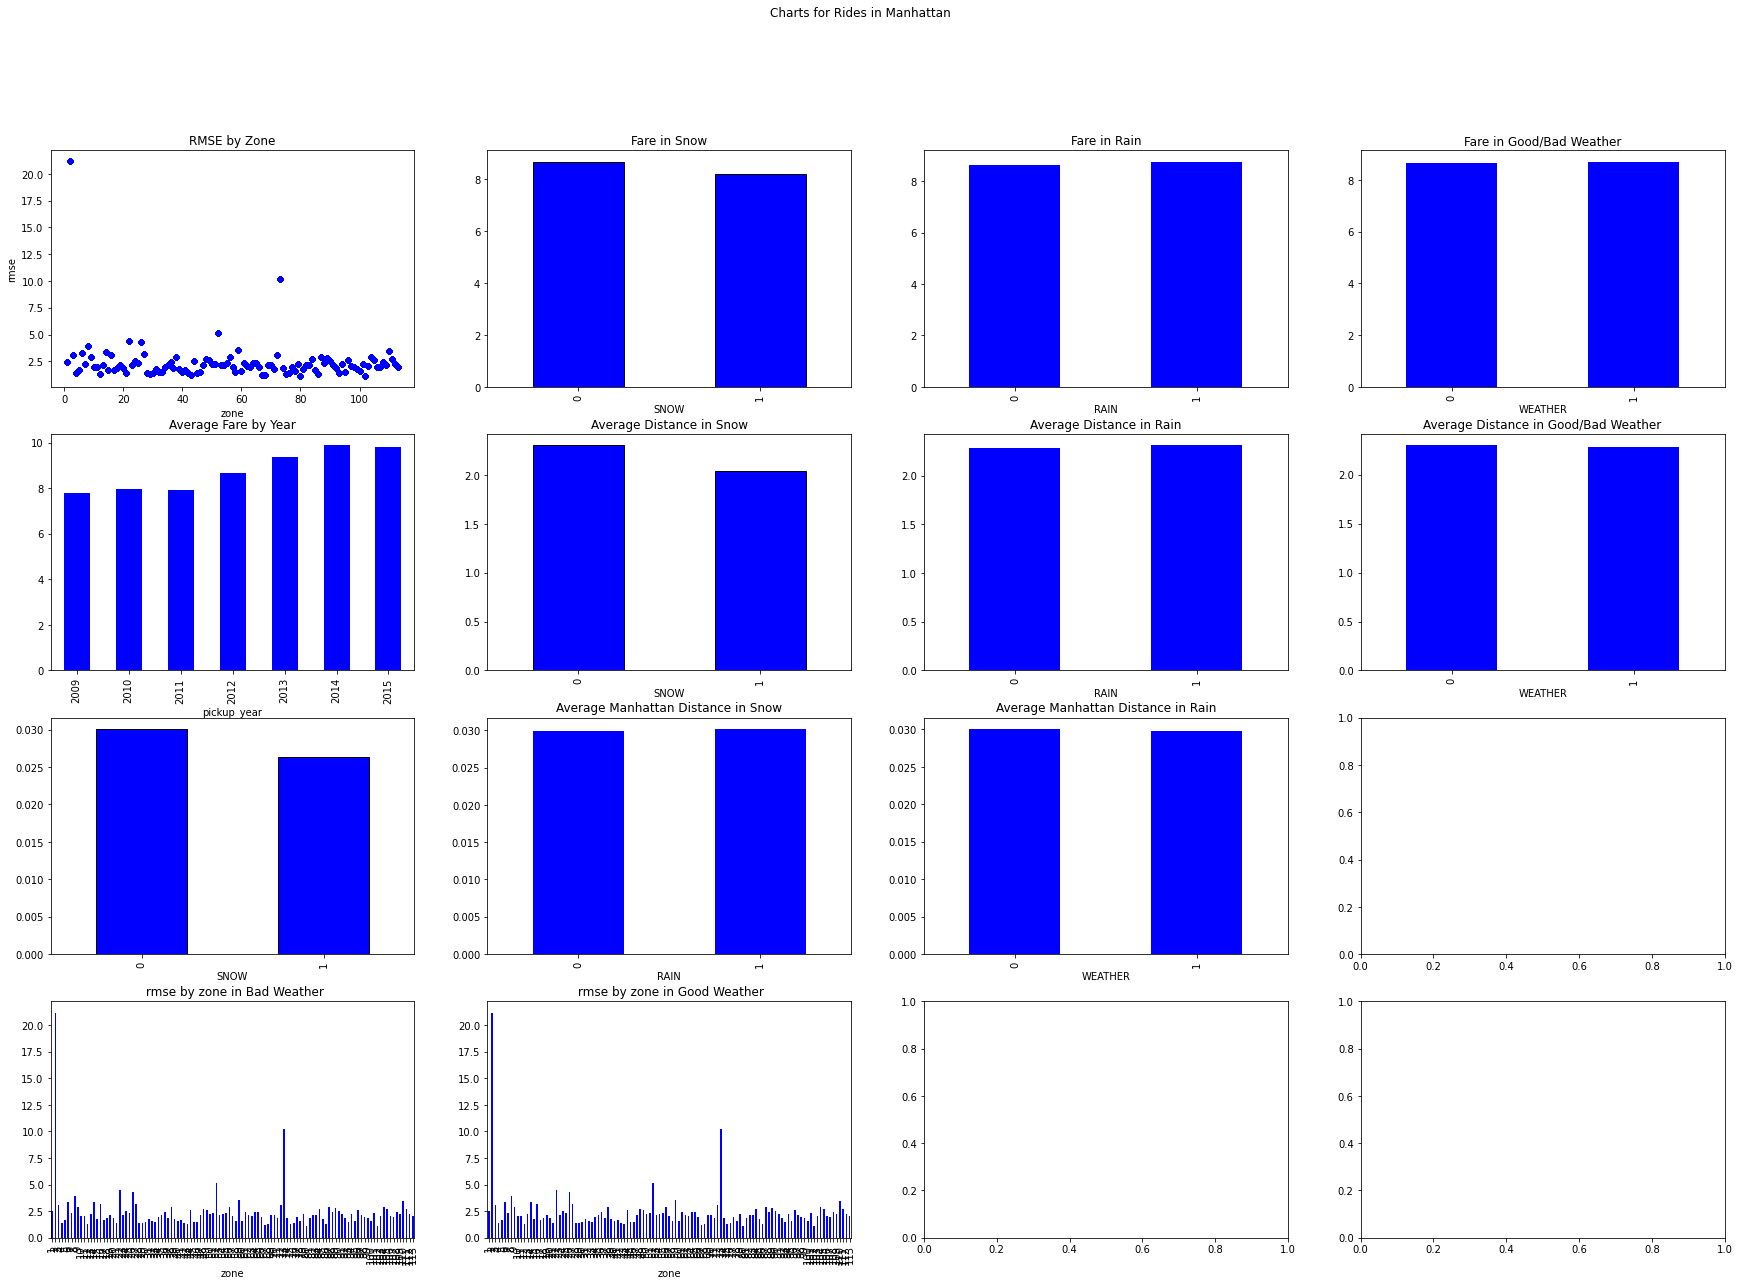

In [ ]:
# data_df['passenger_count'].value_counts().plot(kind="bar",color = 'b', edgecolor = 'k');
fig, ax = plt.subplots(4, 4, figsize=(30, 20))

manhattan_df.plot('zone', 'rmse', kind="scatter",color = 'b', ax=ax[0,0]) 
manhattan_df.groupby('SNOW')['fare_amount'].mean().plot(kind="bar",color = 'b', edgecolor = 'k', ax=ax[0,1]) 
manhattan_df.groupby('RAIN')['fare_amount'].mean().plot(kind="bar",color = 'b', ax=ax[0,2]);
manhattan_df.groupby('WEATHER')['fare_amount'].mean().plot(kind="bar",color = 'b', ax=ax[0,3]);
manhattan_df.groupby('pickup_year')['fare_amount'].mean().plot(kind="bar",color = 'b', ax=ax[1,0]);
manhattan_df.groupby('SNOW')['distance'].mean().plot(kind="bar",color = 'b', edgecolor = 'k', ax=ax[1,1]) 
manhattan_df.groupby('RAIN')['distance'].mean().plot(kind="bar",color = 'b', ax=ax[1,2]);
manhattan_df.groupby('WEATHER')['distance'].mean().plot(kind="bar",color = 'b', ax=ax[1,3]);
manhattan_df.groupby('SNOW')['manhattan'].mean().plot(kind="bar",color = 'b', edgecolor = 'k', ax=ax[2,0]) 
manhattan_df.groupby('RAIN')['manhattan'].mean().plot(kind="bar",color = 'b', ax=ax[2,1]);
manhattan_df.groupby('WEATHER')['manhattan'].mean().plot(kind="bar",color = 'b', ax=ax[2,2]);
good_weather.groupby('zone')['rmse'].mean().plot(kind="bar",color = 'b', ax= ax[3,1])
bad_weather.groupby('zone')['rmse'].mean().plot(kind="bar",color = 'b', ax= ax[3,0])


fig.suptitle('Charts for Rides in Manhattan') # top level title

ax[0,0].set_title('RMSE by Zone')
ax[0,1].set_title('Fare in Snow')
ax[0,2].set_title('Fare in Rain');
ax[0,3].set_title('Fare in Good/Bad Weather');
ax[1,0].set_title('Average Fare by Year');
ax[1,1].set_title('Average Distance in Snow');
ax[1,2].set_title('Average Distance in Rain');
ax[1,3].set_title('Average Distance in Good/Bad Weather');
ax[2,1].set_title('Average Manhattan Distance in Snow');
ax[2,2].set_title('Average Manhattan Distance in Rain');
ax[3,1].set_title(' rmse by zone in Good Weather');
ax[3,0].set_title(' rmse by zone in Bad Weather');

# ax[0,0].set_xlabel('Number of Passengers'); 
# ax[0,0].set_ylabel('Rides');

plt.show()
